In [1]:
from IPython.display import HTML
html = HTML("""
    <style>
        .backtick {
            font-style:oblique;
            font-family:"Courier New";
            font-size:15px;
        }
    </style>
""")
html

**NOTE FROM THE FUTURE (2019-Dec-16)**

<div style="background-color:sandybrown;">
    <p> This was the very first analysis I did during the last week Udi was here, when
        he initially onboarded me onto this project.  Udi was doing some cool stuff, like
        looking at multiple families of models (random forests, XGBoosts, LASSOs, etc), but I
        noticed the generality was at the cost of specific expertise or insight into any
        one particular model family.  </p>
    <p> For example, the random forest grid paramaters for Udi's random
        grid search were not well-informed, IMHO.  The <font class=backtick>max_features</font> parameter 
        only looked at <font class=backtick>auto</font> (which is 1/3 the total number of input 
        features for a RF regression) and <font class=backtick>sqrt</font>; it's good
        to try out values of <font class=backtick>1</font> and <font class=backtick>2</font> here.  Also, 
        <font class=backtick>max_depth</font> had a very limited
        search (<font class=backtick>[3,5,8]</font>); depending on the data set, these could all be nearly
        equivalent depths (e.g., for a forest whose "CART" implementation has  trees reaching 
        a depth of 200 or more).  I find it's usually good to first do a CART random forest,
        which allows trees to grow indefinitely to terminal purity, then to inform the 
        <font class=backtick>max_depth</font>
        portion of a grid search by looking at the tree depth statistics of the CART RF (e.g.,
        min, Q1, median, Q3, max).  This way, you at least know (i) the max depth (no use in 
        have grid search looking at larger depths); (ii) what "light" depth regularization
        looks like (e.g., limiting growth to the CART RF's median depth);  (iii) what
        "more tangible" depth regularization looks like (e.g., limiting growth to the
        CART RF's minimum depth); and (iv) what "solid" and "extreme" depth regularization
        looks like (anything less than the CART RF's minimum is starting to do some real
        work against noise variables, while anything really small might be considered
        extreme...and perhaps not useful).  </p>
    <p> Having a more informed view of a particular model family also allows you to
        optimize your feature representation.  For example, Udi dummy encodes any 
        categorical variable he runs into.  One-hot encoding or dummy encoding is essential
        for linear models, but adds nothing to a random forest.  In fact, in extreme case 
        (categorical variables with 1000s of levels) such an encoding scheme can reduce a
        random forest's performance.  Worse, OH/dummy encoding can obscure the intuitive
        value of feature importances, and so on.  Perhaps unintuitively, the best
        representation for a nominal categorical variable in a RF is an ordinal
        representation -- something that would destroy a linear regression without
        a lot of extra work (e.g., negative effect can be eliminated in this case
        by using a "polyordinal" encoding scheme).  Basically, what I'm saying here 
        is that Udi does a lot more work than he has to if he's going to settle on a
        tree-based model, like RF or XGBoost (which he did in his update report).  </p>
    <p> <b>RESULTS</b>:  ANYWAY, the first thing I did is to apply some of my specialized experience w/ tree-based 
        methods to enhance and extend the general approach taken by Udi.
        You will find a depth regularization search below, followed by an ensemble regularization
        search.  These will culminate in a more complete grid search and some heat maps.  I 
        mostly find that none of this dramatically helps model performance.  Also, I find that
        it's VERY HARD to not overfit the data, and to not do so comes at the cost of
        not doing well on the training or validations sets (i.e., there is no point of
        compromise where training gets worse, but validation gets better: training just
        gets worse, period.)  </p>
    <hr>
    <p style='background-color:orange;'> 
        <b>NOTE</b>: For analyses relevant to final report sent to Gates Foundation, please
        check out notebooks <font class=backtick>01_KU</font> through 
        <font class=backtick>04_KU</font> in <font class=backtick>mbh001/mbh001_v3</font>.
    </p>
    <hr>
    <p style='color:red;background-color:yellow;'><b>NOTE</b>: This notebook is copied to `mbh001_v3/notebooks` where it is prefixed `00a__KU`.</p>
</div>        
        

In [2]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
import pickle
from scipy.stats import zscore,expon

In [3]:
pd.options.display.max_rows = 20

### Load data

In [125]:
d = pickle.load( open( "../../mbh_cu_v2/data/processed/mbh002_f3_toi_mon_baseline_a.p", "rb" ))
print(d.shape)
d.head()

(1548, 577)


,adafppappa.afpga.10,adafppappa.afpga.15,adafppappa.afpga.pre10,adafppappa.afpmom.10,adafppappa.afpmom.15,adafppappa.afpmom.pre10,adafppappa.pappaga.10,adcdrisc.cdrisc_nmiss.15,adcdrisc.cdrisc_nmiss.20,adcdrisc.cdrisc_raw.15,...,adstai.r5_23.101520,adstai.r5_23.cycle.101520,adstai.r5_1.101520,adstai.r5_1.cycle.101520,adstai.r5_16.101520,adstai.r5_16.cycle.101520,adstai.t_anxiety.levels.101520,adstai.s_anxiety.levels.101520,ga_f3,time_left
patid,,,,,,,,,,,,,,,,,,,,,
S002-BISH-00698,155.0,NaN,NaN,0.963352,NaN,NaN,82.0,0.0,NaN,33.0,...,4.0,10,4.0,10,1.0,10,3,3,253.0,25.0
S002-BISH-00751,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,88.0,...,1.0,10,1.0,10,4.0,10,2,2,241.0,32.0
S002-BISH-00809,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,85.0,...,1.0,15,1.0,15,1.0,15,3,2,246.0,20.0
S002-BISH-00860,162.0,NaN,NaN,0.921191,NaN,NaN,NaN,0.0,NaN,75.0,...,3.0,10,1.0,10,3.0,10,3,3,250.0,27.0
S002-BISH-00884,162.0,NaN,NaN,0.864980,NaN,NaN,NaN,0.0,NaN,84.0,...,1.0,10,1.0,10,1.0,10,2,3,241.0,44.0


### Remove sparse features
Keep features missing in less than 20% of the cases

In [126]:
na_th=0.8
#(d.isnull().sum()/len(d)).sort_values()

In [127]:
df = d.dropna(axis=1,thresh=len(d)*na_th)#.select_dtypes('float64')
print(df.shape)
#df=df.astype('float64')
df.dtypes.value_counts()

(1548, 275)


object     169
float64    106
dtype: int64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fa727467240>]],
      dtype=object)

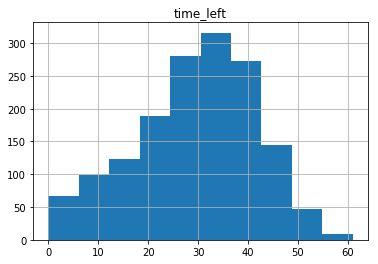

In [128]:
df.filter(like='time_left').hist()

In [129]:
# (df['time_left']<14).value_counts().plot.bar()

Text(0.5,1,'time left as a function of ga at f3')

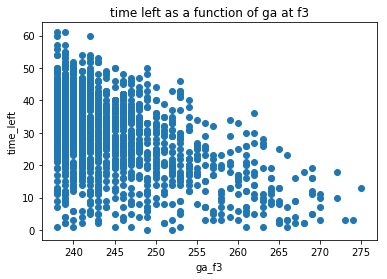

In [130]:
plt.scatter(x=df['ga_f3'],y=df['time_left'])
plt.xlabel('ga_f3')
plt.ylabel('time_left')
plt.title('time left as a function of ga at f3')

### Preparing X and y

In [131]:
X = df.drop(['time_left','ga.birth'],axis=1)
y = df['time_left']

In [132]:
num_feat=X.select_dtypes('float64').columns
cat_feat=X.select_dtypes('object').columns
sensor_features=X.filter(regex='^toi|^mon').columns
#X[cat_feat]=X[cat_feat].astype('str'`)
#X[cat_feat].filter(like='gender')

In [133]:
X[cat_feat].dtypes.value_counts()
X[num_feat].dtypes.value_counts()

float64    104
dtype: int64

In [134]:
# Overlap between feature types
n_X = len(X.columns)
n_num_feat = len(num_feat)
n_cat_feat = len(cat_feat)
n_sensor_features = len(sensor_features)
print('n_X:', n_X)
print('n_num_feat:', n_num_feat)
print('n_cat_feat:', n_cat_feat)
print('n_sensor_features:', n_sensor_features)
print('nn + nc + ns:', n_num_feat + n_cat_feat + n_sensor_features)

n_X: 273
n_num_feat: 104
n_cat_feat: 169
n_sensor_features: 44
nn + nc + ns: 317


## Feature engineering - Numeric



### Creating missing values indicators

In [24]:
X_eng = X.copy()
for feat in num_feat:
    missing_indicator_feat_name = feat+'_nan'
    X_eng[missing_indicator_feat_name] = X[feat].isnull().astype(int)

### Imputing medians

In [25]:
X_eng[num_feat] = X_eng[num_feat].fillna(X[num_feat].median())

## Feature engineering - Categorical
Create dummies removing dirst category

In [26]:
X_eng[cat_feat] = X_eng[cat_feat].astype('float64')

In [27]:
cat_feat_dummies = pd.get_dummies(X_eng[cat_feat], dummy_na=True, drop_first=True)
X_eng = pd.concat([X_eng, cat_feat_dummies], axis=1).drop(cat_feat, axis=1)


# Exploring the Random Forest Baseline Model

In [4]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split

## The Depths of the CART RF

In [33]:
X_train, X_dev, y_train, y_dev = train_test_split(X['ga_f3'], y, test_size=0.3, random_state=42)
X_dev, X_test, y_dev, y_test = train_test_split(X_dev, y_dev, test_size=0.5, random_state=42)

In [92]:
rf0 = RandomForestRegressor(n_estimators=100, n_jobs=-1)

In [93]:
rf0.fit(X_train.values.reshape(-1,1), y_train.values)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [94]:
tree_depths = pd.DataFrame({'depth': [tree.tree_.max_depth for tree in rf0.estimators_]})
tree_depths.describe().loc[['min','25%','50%','75%','max'],:]

,depth
min,7.0
25%,8.0
50%,8.0
75%,9.0
max,10.0


In [108]:
p0 = rf0.predict(X_dev.values.reshape(-1,1))
r2_score(y_dev, p0)

0.25838472148016634

## Depth Regularization:  Effect on R2 Score

In [107]:
rf_depth7 = RandomForestRegressor(n_estimators=100, max_depth=7, n_jobs=-1)
rf_depth7.fit(X_train.values.reshape(-1,1), y_train.values)
rf = rf_depth7
#
tree_depths = pd.DataFrame({'depth': [tree.tree_.max_depth for tree in rf.estimators_]})
print(tree_depths.describe().loc[['min','25%','50%','75%','max'],:])
p = rf.predict(X_dev.values.reshape(-1,1))
r2_score(y_dev, p)

     depth
min    7.0
25%    7.0
50%    7.0
75%    7.0
max    7.0


0.26020047520394773

In [110]:
rf_depth6 = RandomForestRegressor(n_estimators=100, max_depth=6, n_jobs=-1)
rf_depth6.fit(X_train.values.reshape(-1,1), y_train.values)
rf = rf_depth6
#
tree_depths = pd.DataFrame({'depth': [tree.tree_.max_depth for tree in rf.estimators_]})
print(tree_depths.describe().loc[['min','25%','50%','75%','max'],:])
p = rf.predict(X_dev.values.reshape(-1,1))
r2_score(y_dev, p)

     depth
min    6.0
25%    6.0
50%    6.0
75%    6.0
max    6.0


0.2572170308955142

In [111]:
rf_depth5 = RandomForestRegressor(n_estimators=100, max_depth=5, n_jobs=-1)
rf_depth5.fit(X_train.values.reshape(-1,1), y_train.values)
rf = rf_depth5
#
tree_depths = pd.DataFrame({'depth': [tree.tree_.max_depth for tree in rf.estimators_]})
print(tree_depths.describe().loc[['min','25%','50%','75%','max'],:])
p = rf.predict(X_dev.values.reshape(-1,1))
r2_score(y_dev, p)

     depth
min    5.0
25%    5.0
50%    5.0
75%    5.0
max    5.0


0.25892240384689513

In [112]:
rf_depth4 = RandomForestRegressor(n_estimators=100, max_depth=4, n_jobs=-1)
rf_depth4.fit(X_train.values.reshape(-1,1), y_train.values)
rf = rf_depth4
#
tree_depths = pd.DataFrame({'depth': [tree.tree_.max_depth for tree in rf.estimators_]})
print(tree_depths.describe().loc[['min','25%','50%','75%','max'],:])
p = rf.predict(X_dev.values.reshape(-1,1))
r2_score(y_dev, p)

     depth
min    4.0
25%    4.0
50%    4.0
75%    4.0
max    4.0


0.26150881483302346

In [113]:
rf_depth3 = RandomForestRegressor(n_estimators=100, max_depth=3, n_jobs=-1)
rf_depth3.fit(X_train.values.reshape(-1,1), y_train.values)
rf = rf_depth3
#
tree_depths = pd.DataFrame({'depth': [tree.tree_.max_depth for tree in rf.estimators_]})
print(tree_depths.describe().loc[['min','25%','50%','75%','max'],:])
p = rf.predict(X_dev.values.reshape(-1,1))
r2_score(y_dev, p)

     depth
min    3.0
25%    3.0
50%    3.0
75%    3.0
max    3.0


0.2655539306741942

In [114]:
rf_depth2 = RandomForestRegressor(n_estimators=100, max_depth=2, n_jobs=-1)
rf_depth2.fit(X_train.values.reshape(-1,1), y_train.values)
rf = rf_depth2
#
tree_depths = pd.DataFrame({'depth': [tree.tree_.max_depth for tree in rf.estimators_]})
print(tree_depths.describe().loc[['min','25%','50%','75%','max'],:])
p = rf.predict(X_dev.values.reshape(-1,1))
r2_score(y_dev, p)

     depth
min    2.0
25%    2.0
50%    2.0
75%    2.0
max    2.0


0.2569040679364345

### SUMMARY
For 100 trees:

| max_depth | r2 score |
|-----------|----------|
|   None    | 0.258 |
| 7 | 0.260 |
| 6 | 0.257 |
| 5 | 0.260 |
| 4 | 0.262 |
| 3 | **0.266** |
| 2 | 0.257 |

# Ensemble Regularization:  Larger Forests

In [120]:
rf_100 = RandomForestRegressor(n_estimators=100, max_depth=3, n_jobs=-1)
rf_100.fit(X_train.values.reshape(-1,1), y_train.values)
rf = rf_100
#
tree_depths = pd.DataFrame({'depth': [tree.tree_.max_depth for tree in rf.estimators_]})
print(tree_depths.describe().loc[['min','25%','50%','75%','max'],:])
p = rf.predict(X_dev.values.reshape(-1,1))
r2_score(y_dev, p)

     depth
min    3.0
25%    3.0
50%    3.0
75%    3.0
max    3.0


0.26614107162575096

In [118]:
rf_200 = RandomForestRegressor(n_estimators=200, max_depth=3, n_jobs=-1)
rf_200.fit(X_train.values.reshape(-1,1), y_train.values)
rf = rf_200
#
tree_depths = pd.DataFrame({'depth': [tree.tree_.max_depth for tree in rf.estimators_]})
print(tree_depths.describe().loc[['min','25%','50%','75%','max'],:])
p = rf.predict(X_dev.values.reshape(-1,1))
r2_score(y_dev, p)

     depth
min    3.0
25%    3.0
50%    3.0
75%    3.0
max    3.0


0.2646670647890452

In [119]:
rf_500 = RandomForestRegressor(n_estimators=500, max_depth=3, n_jobs=-1)
rf_500.fit(X_train.values.reshape(-1,1), y_train.values)
rf = rf_500
#
tree_depths = pd.DataFrame({'depth': [tree.tree_.max_depth for tree in rf.estimators_]})
print(tree_depths.describe().loc[['min','25%','50%','75%','max'],:])
p = rf.predict(X_dev.values.reshape(-1,1))
r2_score(y_dev, p)

     depth
min    3.0
25%    3.0
50%    3.0
75%    3.0
max    3.0


0.26531136189163196

In [115]:
rf_1000 = RandomForestRegressor(n_estimators=1000, max_depth=3, n_jobs=-1)
rf_1000.fit(X_train.values.reshape(-1,1), y_train.values)
rf = rf_1000
#
tree_depths = pd.DataFrame({'depth': [tree.tree_.max_depth for tree in rf.estimators_]})
print(tree_depths.describe().loc[['min','25%','50%','75%','max'],:])
p = rf.predict(X_dev.values.reshape(-1,1))
r2_score(y_dev, p)

     depth
min    3.0
25%    3.0
50%    3.0
75%    3.0
max    3.0


0.26462985504356384

In [116]:
rf_5000 = RandomForestRegressor(n_estimators=5000, max_depth=3, n_jobs=-1)
rf_5000.fit(X_train.values.reshape(-1,1), y_train.values)
rf = rf_5000
#
tree_depths = pd.DataFrame({'depth': [tree.tree_.max_depth for tree in rf.estimators_]})
print(tree_depths.describe().loc[['min','25%','50%','75%','max'],:])
p = rf.predict(X_dev.values.reshape(-1,1))
r2_score(y_dev, p)

     depth
min    3.0
25%    3.0
50%    3.0
75%    3.0
max    3.0


0.2648114824623461

In [117]:
rf_10k = RandomForestRegressor(n_estimators=10000, max_depth=3, n_jobs=-1)
rf_10k.fit(X_train.values.reshape(-1,1), y_train.values)
rf = rf_10k
#
tree_depths = pd.DataFrame({'depth': [tree.tree_.max_depth for tree in rf.estimators_]})
print(tree_depths.describe().loc[['min','25%','50%','75%','max'],:])
p = rf.predict(X_dev.values.reshape(-1,1))
r2_score(y_dev, p)

     depth
min    3.0
25%    3.0
50%    3.0
75%    3.0
max    3.0


0.2648205233144222

In [121]:
rf_30k = RandomForestRegressor(n_estimators=30000, max_depth=3, n_jobs=-1)
rf_30k.fit(X_train.values.reshape(-1,1), y_train.values)
rf = rf_30k
#
tree_depths = pd.DataFrame({'depth': [tree.tree_.max_depth for tree in rf.estimators_]})
print(tree_depths.describe().loc[['min','25%','50%','75%','max'],:])
p = rf.predict(X_dev.values.reshape(-1,1))
r2_score(y_dev, p)

     depth
min    3.0
25%    3.0
50%    3.0
75%    3.0
max    3.0


0.2650037280662364

In [122]:
rf_100k = RandomForestRegressor(n_estimators=100000, max_depth=3, n_jobs=-1)
rf_100k.fit(X_train.values.reshape(-1,1), y_train.values)
rf = rf_100k
#
tree_depths = pd.DataFrame({'depth': [tree.tree_.max_depth for tree in rf.estimators_]})
print(tree_depths.describe().loc[['min','25%','50%','75%','max'],:])
p = rf.predict(X_dev.values.reshape(-1,1))
r2_score(y_dev, p)

     depth
min    3.0
25%    3.0
50%    3.0
75%    3.0
max    3.0


0.26492849600412194

For max depth of 3:
    
| nTrees | r2 score |
|----|----|
| 100 | **0.266** |
| 200 | 0.265 | 
| 500 | 0.265 |
| 1000 | 0.265 | 
| 5000 | 0.265 |
| 10k | 0.265 |
| 30k | 0.265 |
| 100k | 0.265 |

# Does X_eng work better?

In [135]:
X_eng_train, X_eng_dev, y_eng_train, y_eng_dev = train_test_split(X['ga_f3'], y, test_size=0.3, random_state=42)
X_eng_dev, X_eng_test, y_eng_dev, y_eng_test = train_test_split(X_eng_dev, y_eng_dev, test_size=0.5, random_state=42)

In [136]:
rf_eng = RandomForestRegressor(n_estimators=100, max_depth=3, n_jobs=-1)
rf_eng.fit(X_eng_train.values.reshape(-1,1), y_eng_train.values)
rf = rf_eng
#
tree_depths = pd.DataFrame({'depth': [tree.tree_.max_depth for tree in rf.estimators_]})
print(tree_depths.describe().loc[['min','25%','50%','75%','max'],:])
p = rf.predict(X_dev.values.reshape(-1,1))
r2_score(y_dev, p)

     depth
min    3.0
25%    3.0
50%    3.0
75%    3.0
max    3.0


0.26640929498948085

In [137]:
rf_eng = RandomForestRegressor(n_estimators=100, max_depth=7, n_jobs=-1)
rf_eng.fit(X_eng_train.values.reshape(-1,1), y_eng_train.values)
rf = rf_eng
#
tree_depths = pd.DataFrame({'depth': [tree.tree_.max_depth for tree in rf.estimators_]})
print(tree_depths.describe().loc[['min','25%','50%','75%','max'],:])
p = rf.predict(X_dev.values.reshape(-1,1))
r2_score(y_dev, p)

     depth
min    7.0
25%    7.0
50%    7.0
75%    7.0
max    7.0


0.2584372768103831

In [138]:
rf_eng = RandomForestRegressor(n_estimators=1000, max_depth=5, n_jobs=-1)
rf_eng.fit(X_eng_train.values.reshape(-1,1), y_eng_train.values)
rf = rf_eng
#
tree_depths = pd.DataFrame({'depth': [tree.tree_.max_depth for tree in rf.estimators_]})
print(tree_depths.describe().loc[['min','25%','50%','75%','max'],:])
p = rf.predict(X_dev.values.reshape(-1,1))
r2_score(y_dev, p)

     depth
min    5.0
25%    5.0
50%    5.0
75%    5.0
max    5.0


0.2588221836879365

# Baseline + DemoClinical

In [146]:
X_fill = X.fillna(-99999)

In [147]:
X_dc_train, X_dc_dev, y_dc_train, y_dc_dev = train_test_split(X_fill.drop(sensor_features,axis=1), y, test_size=0.3, random_state=42)
X_dc_dev, X_dc_test, y_dc_dev, y_dc_test = train_test_split(X_dc_dev, y_dc_dev, test_size=0.5, random_state=42)

## Depths of the CART RF

In [154]:
rf_dc = RandomForestRegressor(n_estimators=100, n_jobs=-1)
rf_dc.fit(X_dc_train.values, y_dc_train.values)
rf = rf_dc
#
tree_depths = pd.DataFrame({'depth': [tree.tree_.max_depth for tree in rf.estimators_]})
print(tree_depths.describe().loc[['min','25%','50%','75%','max'],:])
p = rf.predict(X_dc_dev.values)
r2_score(y_dc_dev, p)

     depth
min  17.00
25%  20.75
50%  22.00
75%  23.00
max  27.00


0.3122216167942006

## Depth Regularization

In [182]:
def rf_r2(
    x_train,
    y_train,
    x_dev,
    y_dev,
    n_estimators = [100],
    max_depth = [3],
    n_jobs = -1,
):
    df = pd.DataFrame(columns=['n_estimators','max_depth','r2_score'])
    for num in n_estimators:
        for depth in max_depth:
            rf = RandomForestRegressor(n_estimators=num, max_depth=depth, n_jobs=-1)
            rf.fit(x_train.values, y_train.values)
            p = rf.predict(X_dc_dev.values)
            r2 = r2_score(y_dc_dev, p)
            df.loc[len(df)] = [num, depth, r2]
    return df

In [184]:
df = rf_r2(X_dc_train, y_dc_train, X_dc_dev, y_dc_dev,
          n_estimators = [100],
          max_depth = np.arange(2,27))

In [191]:
df.sort_values('r2_score', ascending=False).head()

,n_estimators,max_depth,r2_score
7,100.0,9.0,0.326664
10,100.0,12.0,0.319505
11,100.0,13.0,0.318840
17,100.0,19.0,0.315918
14,100.0,16.0,0.313445


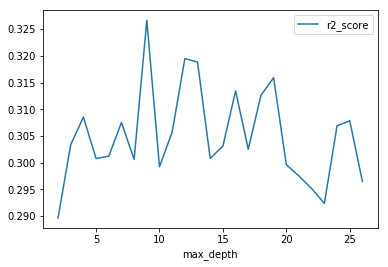

In [192]:
df.plot('max_depth','r2_score')

## Ensemble Regularization
Max depth of 9 worked best, so we'll first hold that constant.

In [193]:
df = rf_r2(X_dc_train, y_dc_train, X_dc_dev, y_dc_dev,
          n_estimators = [100, 200, 500, 1000, 5000, 10000, 20000, 50000],
          max_depth = [9])

In [197]:
df.sort_values('r2_score', ascending=False).head(10)

,n_estimators,max_depth,r2_score
3,1000.0,9.0,0.318701
4,5000.0,9.0,0.315697
5,10000.0,9.0,0.315271
2,500.0,9.0,0.315202
7,50000.0,9.0,0.314904
6,20000.0,9.0,0.314683
1,200.0,9.0,0.308549
0,100.0,9.0,0.298612


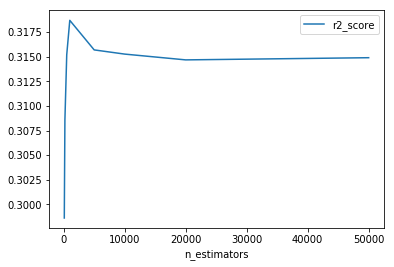

In [196]:
df.plot('n_estimators','r2_score')

## Ensemble+Depth Reg

In [198]:
df = rf_r2(X_dc_train, y_dc_train, X_dc_dev, y_dc_dev,
          n_estimators = [100, 250, 500, 750, 1000, 1250, 1500, 1750, 2000, 2500, 3000, 3500, 4000, 4500, 5000],
          max_depth = np.arange(7,16))

In [199]:
df.sort_values('r2_score', ascending=False).head(10)

,n_estimators,max_depth,r2_score
0,100.0,7.0,0.328143
41,1000.0,12.0,0.322179
44,1000.0,15.0,0.321935
32,750.0,12.0,0.321214
86,2500.0,12.0,0.320130
26,500.0,15.0,0.320057
10,250.0,8.0,0.319425
48,1250.0,10.0,0.319245
15,250.0,13.0,0.318566
3,100.0,10.0,0.318304


In [200]:
import seaborn as sns

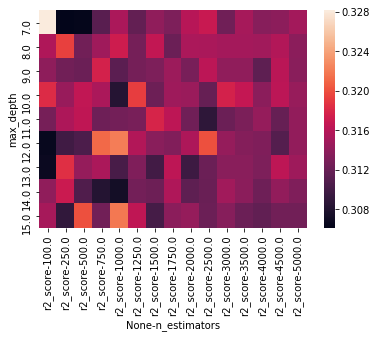

In [206]:

sns.heatmap(df.pivot('max_depth','n_estimators'))

In [207]:
df_ = rf_r2(X_dc_train, y_dc_train, X_dc_dev, y_dc_dev,
          n_estimators = [10,20,30,40,50,60,70,80,90],
          max_depth = np.arange(7,16))

In [209]:
data = pd.concat([df,df_])

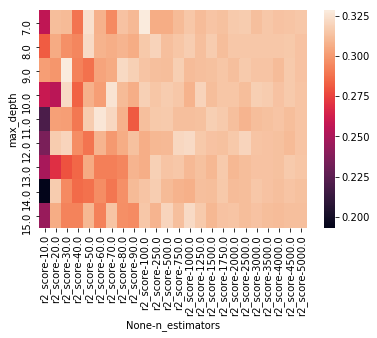

In [210]:
sns.heatmap(data.pivot('max_depth','n_estimators'))

In [213]:
data.sort_values('r2_score', ascending=False).head(10)

,n_estimators,max_depth,r2_score
0,100.0,7.0,0.328143
20,30.0,9.0,0.328127
49,60.0,11.0,0.326124
57,70.0,10.0,0.325131
36,50.0,7.0,0.324343
41,1000.0,12.0,0.322179
21,30.0,10.0,0.322129
44,1000.0,15.0,0.321935
37,50.0,8.0,0.321921
65,80.0,9.0,0.321487


In [214]:
df__ = rf_r2(X_dc_train, y_dc_train, X_dc_dev, y_dc_dev,
          n_estimators = [10,20,30,40,50,60,70,80,90,100, 250, 500, 750, 1000, 1250, 1500, 1750, 2000, 2500, 3000, 3500, 4000, 4500, 5000],
          max_depth = np.arange(2,7))

In [215]:
data_ = pd.concat([data,df__])

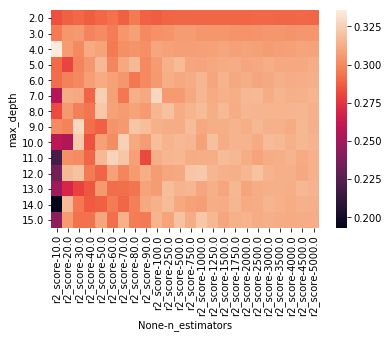

In [216]:
sns.heatmap(data_.pivot('max_depth','n_estimators'))

In [217]:
data_.sort_values('r2_score', ascending=False).head(10)

,n_estimators,max_depth,r2_score
2,10.0,4.0,0.335395
0,100.0,7.0,0.328143
20,30.0,9.0,0.328127
49,60.0,11.0,0.326124
57,70.0,10.0,0.325131
36,50.0,7.0,0.324343
41,1000.0,12.0,0.322179
21,30.0,10.0,0.322129
44,1000.0,15.0,0.321935
37,50.0,8.0,0.321921


## train model function
**The stuff below is originally from Udi's `modeling_f3_baseline` notebook**

In [16]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, median_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import ElasticNet

In [17]:
def train_model_cv(
    X_train,
    y_train,
    model='lasso',
    n_iter=50,
    kfolds=3
):
    ''' Function to fit a model and tune hyper parameters using five fold cross validation
       
    Parameters
    ----------
    X_train : training features
    Y_train: training target
    model: model name
    '''
    
    regs={'lasso': Lasso(selection='random',random_state=42),
          'rf':RandomForestRegressor(random_state=42),
          'xgbtree':XGBRegressor(silent=True,early_stopping_rounds=10,eval_metric="mae",eval_set=[(X_train,y_train)],random_state=42),
          'xgbdart':XGBRegressor(silent=True,early_stopping_rounds=10,eval_set=[(X_train,y_train)],booster='dart',random_state=42),
          'xgblinear':XGBRegressor(silent=True,early_stopping_rounds=10,eval_set=[(X_train,y_train)],booster='gblinear',random_state=42),
          'gbmreg':GradientBoostingRegressor(loss='quantile',random_state=42),
         'enet':ElasticNet(selection='random',random_state=42)}
    grids = {'lasso':
                {'alpha':[0.1,0.2,0.3,0.4,0.5,1,2,5],
                 'normalize':[True,False],
                 'positive':[True,False]
                },
             'enet':
                {'alpha':[0.1,0.2,0.3,0.4,0.5,1,2,5],
                 'l1_ratio':[0,0.5,1],
                 'normalize':[False],
                 'positive':[True,False]
                },
             'rf':
                {'n_estimators': [10,100,500,1000],
                 'max_features': ['auto','sqrt'],
                 'max_depth': [3,5,8],
                 'min_samples_split':[2, 5, 10],
                 'min_samples_leaf':[1, 2, 4]
                },
             'xgbtree':
                 {'learning_rate': expon(scale=.1),
                  'max_depth': [2,3,5],
                  'n_estimators': [10,100,200,500],
                  'subsample':[0.5,0.8,1],
                  'alpha':[1,5,10,20,50],
                  'gamma':[20,50,100,200],
                  'lambda': [0.1,0.2,0.3,0.4,0.5,1,2,5],
                  'rate_drop':[0,0.2,0.4,0.6,0.8,1]},
             'xgbdart':
                 {'learning_rate': expon(scale=.1),
                  'max_depth': [2,3,5],
                  'n_estimators': [10,100,200,500],
                  'subsample':[0.5,0.8,1],
                  'rate_drop':[0,0.2,0.4,0.6,0.8,1]},
             'xgblinear':
                 {'alpha':[0.1,1,5,10],
                  'lambda': [0.1,0.2,0.3,0.4,0.5,1,2,5],
                  'n_estimators': [10,100,200,500],
                  'subsample':[0.5,0.8,1],
                  'rate_drop':[0,0.2,0.4,0.6,0.8,1]},
             'gbmreg':{'n_estimators': [10,100,250],
                 'max_depth': [3,5,8],
                 'min_samples_split':[2, 5, 10,20],
                 'min_samples_leaf':[2, 5, 10,20]
                }
            }
    
    reg=RandomizedSearchCV(regs[model],
                           grids[model],
                           n_jobs=-1,
                           cv=kfolds,
                           n_iter=n_iter,
                           return_train_score=True,
                           scoring=['r2','neg_mean_absolute_error','neg_median_absolute_error'],
                          refit='neg_mean_absolute_error')
    reg.fit(X_train,y_train)
    return(reg)